In [1]:
import pandas as pd
import requests
from datetime import datetime
import xml.etree.ElementTree as ET
from io import StringIO
import time
import warnings

warnings.filterwarnings("ignore")

# Построение причинно-следственного графа для прогнозирования доли NPL

## 1. Постановка задачи и определения

### 1.1. Целевая переменная

NPL Ratio (Non-Performing Loans Ratio) – доля проблемных кредитов:NPL_ratio = NPL_volume / Total_loan_portfolioгде NPL обычно определяются как кредиты с просрочкой платежей более 0+ дней.

### 1.2. Цель построения графа
Идентифицировать причинные механизмы, влияющие на NPL ratio, для построения прогнозной модели, устойчивой к изменениям макроэкономических условий и кредитной политики.

## 2. Подготовительный этап

### 2.1. Сбор данных

In [2]:
month_dict = {
    'январь': 1, 'jan': 1, 'I квартал': 1,
    'февраль': 2, 'feb': 2,
    'март': 3, 'mar': 3,
    'апрель': 4, 'apr': 4, 'II квартал': 4, 
    'май': 5, 'may': 5,
    'июнь': 6, 'jun': 6,
    'июль': 7, 'jul': 7, 'III квартал': 7,
    'август': 8, 'aug': 8,
    'сентябрь': 9, 'sep': 9,
    'октябрь': 10, 'oct': 10, 'IV квартал': 10,
    'ноябрь': 11, 'nov': 11,
    'декабрь': 12, 'dec': 12,
}

In [3]:
import datetime

def create_date(row):
    try:
        return datetime.datetime(row['Year'].astype(int), row['Month'].astype(int), 1)
    except:
        return datetime.datetime(row['Year'], row['Month'], 1)

#### NPL Ratio

In [5]:
NPL_after_2019_df = pd.read_excel('data/NPL_после2019.xlsx', skiprows=1, sheet_name='в т.ч.просроч.')
NPL_after_2019_df = NPL_after_2019_df.T
NPL_after_2019_df = NPL_after_2019_df[NPL_after_2019_df.columns[:1]].reset_index().drop(0, axis=0)
NPL_after_2019_df.columns = ['Дата', 'NPL']
NPL_after_2019_df.head()

,Дата,NPL
1,2019-02-01 00:00:00,2164326
2,2019-03-01 00:00:00,2203813
3,2019-04-01 00:00:00,2234316
4,2019-05-01 00:00:00,2265258
5,2019-06-01 00:00:00,2334158


In [6]:
PL_after_2019_df = pd.read_excel('data/NPL_после2019.xlsx', skiprows=1, sheet_name='итого')
PL_after_2019_df = PL_after_2019_df.T
PL_after_2019_df = PL_after_2019_df[PL_after_2019_df.columns[:1]].reset_index().drop(0, axis=0)
PL_after_2019_df.columns = ['Дата', 'PL']
PL_after_2019_df.head()

,Дата,PL
1,2019-02-01 00:00:00,31650115
2,2019-03-01 00:00:00,31679415
3,2019-04-01 00:00:00,31779885
4,2019-05-01 00:00:00,31886882
5,2019-06-01 00:00:00,31957999


In [7]:
NPL_before_2019_df = pd.read_excel('data/Регресионный_подход_макропоправка_на_30_09_2025_NPL.xlsx', 
                                   skiprows=6, sheet_name='Non-performing_before_2019')
NPL_before_2019_df = NPL_before_2019_df[NPL_before_2019_df.columns[:2]]
NPL_before_2019_df.columns = ['Дата', 'NPL']
NPL_before_2019_df.head()

,Дата,NPL
0,2009-04-01,346769
1,2009-05-01,380065
2,2009-06-01,409667
3,2009-07-01,428450
4,2009-08-01,478269


In [8]:
PL_before_2019_df = pd.read_excel('data/Регресионный_подход_макропоправка_на_30_09_2025_NPL.xlsx', 
                                  skiprows=6, sheet_name='Total_before_2019')
PL_before_2019_df = PL_before_2019_df[PL_before_2019_df.columns[:2]]
PL_before_2019_df.columns = ['Дата', 'PL']
PL_before_2019_df.head()

,Дата,PL
0,2009-04-01,9174235
1,2009-05-01,9122247
2,2009-06-01,9140944
3,2009-07-01,9063617
4,2009-08-01,9043354


In [9]:
NPL_ratio_df = pd.concat([NPL_before_2019_df.merge(PL_before_2019_df, on='Дата'),
                          NPL_after_2019_df.merge(PL_after_2019_df, on='Дата')], axis = 0)
NPL_ratio_df['NPL_rate'] = NPL_ratio_df['NPL']/NPL_ratio_df['PL']
NPL_ratio_df.Дата = pd.to_datetime(NPL_ratio_df.Дата)
NPL_ratio_df.head()

,Дата,NPL,PL,NPL_rate
0,2009-04-01,346769,9174235,0.037798
1,2009-05-01,380065,9122247,0.041664
2,2009-06-01,409667,9140944,0.044817
3,2009-07-01,428450,9063617,0.047271
4,2009-08-01,478269,9043354,0.052886


#### GDP_growth – темп роста ВВП

In [33]:
GDP_df_1 = pd.read_excel('data/VVP_kvartal_s_1995-2025.xlsx', sheet_name='1', skiprows=2)
GDP_df_1 = GDP_df_1.iloc[:2]
GDP_df_1 = GDP_df_1.T.reset_index()
GDP_df_1 = GDP_df_1[:-4]

GDP_df_2 = pd.read_excel('data/VVP_kvartal_s_1995-2025.xlsx', sheet_name='2', skiprows=2)
GDP_df_2 = GDP_df_2.iloc[:2]
GDP_df_2 = GDP_df_2.T.reset_index()

GDP_df = pd.concat([GDP_df_1, GDP_df_2])
GDP_df['index'] = pd.to_numeric(GDP_df['index'], errors='coerce').ffill()
GDP_df[0] = GDP_df[0].str.strip().map(month_dict)
GDP_df.columns = ['Year', 'Month', 'GDP']
GDP_df = GDP_df.dropna()
GDP_df['Дата'] = pd.to_datetime(
    GDP_df['Year'].astype(int).astype(str) + '-' + GDP_df['Month'].astype(int).astype(str) + '-01',
    format='%Y-%m-%d')
GDP_df['GDP_growth'] = (GDP_df.GDP + GDP_df.GDP.shift(1) + GDP_df.GDP.shift(2) + GDP_df.GDP.shift(3))\
    / (GDP_df.GDP.shift(4) + GDP_df.GDP.shift(5) + GDP_df.GDP.shift(6) + GDP_df.GDP.shift(7))
GDP_df.tail(10)

,Year,Month,GDP,Дата,GDP_growth
50,2023.0,4.0,40737.945036,2023-04-01,1.069665
51,2023.0,7.0,46199.683219,2023-07-01,1.088112
52,2023.0,10.0,52554.429097,2023-10-01,1.124076
53,2024.0,1.0,44133.688562,2024-01-01,1.171645
54,2024.0,4.0,47281.918764,2024-04-01,1.188141
55,2024.0,7.0,50857.061407,2024-07-01,1.16593
56,2024.0,10.0,58879.423425,2024-10-01,1.14023
57,2025.0,1.0,47746.813063,2025-01-01,1.115123
58,2025.0,4.0,49516.817095,2025-04-01,1.088502
59,2025.0,7.0,54501.346898,2025-07-01,1.081186


#### Unemployment_rate – уровень безработицы

* https://fedstat.ru/indicator/57341
* https://ru.tradingview.com/symbols/ECONOMICS-RUUR/?timeframe=60M

In [34]:
Unemployment_rate_2022_df = pd.read_excel('data/Unemployment_rate.xlsx', skiprows = 3)
Unemployment_rate_2022_df['Unemployment_rate'] = Unemployment_rate_2022_df['Российская Федерация'].fillna(Unemployment_rate_2022_df['Российская Федерация.1'])
Unemployment_rate_2022_df = Unemployment_rate_2022_df[['Unnamed: 0', 'Unnamed: 1', 'Unemployment_rate']]
Unemployment_rate_2022_df.columns = ['Year', 'Month', 'Unemployment_rate']
Unemployment_rate_2022_df.Month = Unemployment_rate_2022_df.Month.str.lower().str.strip().map(month_dict)
Unemployment_rate_2022_df.tail(10)

,Year,Month,Unemployment_rate
86,2022,3,4.1
87,2022,4,4.0
88,2022,5,3.9
89,2022,6,4.0
90,2022,7,3.9
91,2022,8,3.8
92,2022,9,3.9
93,2022,10,3.9
94,2022,11,3.7
95,2022,12,3.7


In [35]:
Unemployment_rate_2025_df = pd.read_excel('data/Unemployment_rate_new.xlsx')
Unemployment_rate_2025_df.tail(5)

,Year,Month,Unemployment_rate
30,2025,7,2.2
31,2025,8,2.2
32,2025,9,2.1
33,2025,10,2.2
34,2025,11,2.2


In [36]:
Unemployment_rate_df = pd.concat([Unemployment_rate_2022_df, Unemployment_rate_2025_df])
Unemployment_rate_df['Дата'] = Unemployment_rate_df.apply(create_date, axis=1)
Unemployment_rate_df.sample()

,Year,Month,Unemployment_rate,Дата
26,2025,3,2.3,2025-03-01


#### Ставка ЦБ

In [37]:
IR_df = pd.read_excel('data/IR_CHG_MPOFull.xlsx', skiprows = 2)
IR_df = IR_df[['Дата', 'Ключевая ставка']]
IR_df = IR_df.dropna()
IR_df = IR_df.query("`Ключевая ставка` != ' — ' ")
IR_df.Дата = pd.to_datetime(IR_df.Дата)
IR_df['Дата'] = IR_df.Дата.apply(lambda x: x.to_period('M').to_timestamp())
IR_df = IR_df.drop_duplicates('Дата', keep='first')
IR_df

,Дата,Ключевая ставка
96,2013-09-01,5.5
97,2014-02-01,5.5
99,2014-03-01,7
100,2014-04-01,7
102,2014-06-01,7.5
...,...,...
168,2024-10-01,21
169,2025-06-01,20
170,2025-07-01,18
171,2025-09-01,17


#### Инфляция

In [38]:
inflation_df = pd.read_excel('data/Инфляция.xlsx')
inflation_df = pd.melt(inflation_df, value_vars = inflation_df.columns[1:-1], var_name = 'Month', 
id_vars = 'Year', value_name='Inflation_Rate')
inflation_df.Month = inflation_df.Month.str.lower().str.strip().map(month_dict)
inflation_df.Inflation_Rate = pd.to_numeric(inflation_df.Inflation_Rate.str.replace('%', '').str.replace(',', ''))

inflation_df['Дата'] = inflation_df.apply(create_date, axis=1)
inflation_df

,Year,Month,Inflation_Rate,Дата
0,2025,1,10.0,2025-01-01
1,2024,1,7.4,2024-01-01
2,2023,1,11.8,2023-01-01
3,2022,1,8.7,2022-01-01
4,2021,1,5.2,2021-01-01
...,...,...,...,...
391,1997,12,11.0,1997-12-01
392,1996,12,21.9,1996-12-01
393,1995,12,131.1,1995-12-01
394,1994,12,216.1,1994-12-01


### Индекс потребительских цен

In [39]:
IPC_df = pd.read_excel('data/ipc_mes_10-2025.xlsx', skiprows=3, sheet_name='01')
IPC_df = IPC_df.iloc[1:13]
IPC_df = IPC_df.melt(id_vars = 'Unnamed: 0', value_vars=IPC_df.columns[1:])
IPC_df.columns = ['Month', 'Year', 'IPC_rate']
IPC_df = IPC_df.query("IPC_rate.notna()")
IPC_df.Month = IPC_df.Month.str.lower().str.strip().map(month_dict)
IPC_df['Дата'] = IPC_df.apply(create_date, axis=1)
IPC_df.IPC_rate = pd.to_numeric(IPC_df.IPC_rate)
IPC_df

,Month,Year,IPC_rate,Дата
0,1,1991,106.20,1991-01-01
1,2,1991,104.80,1991-02-01
2,3,1991,106.30,1991-03-01
3,4,1991,163.50,1991-04-01
4,5,1991,103.00,1991-05-01
...,...,...,...,...
413,6,2025,100.20,2025-06-01
414,7,2025,100.57,2025-07-01
415,8,2025,99.60,2025-08-01
416,9,2025,100.34,2025-09-01


### Рост доходов населения, г/г

In [40]:
income_df = pd.read_excel('data/tab1-zpl_09-2025.xlsx', skiprows = 4)
income_df = income_df.iloc[3:37]
income_df = income_df.melt(id_vars = 'Unnamed: 0', value_vars=income_df.columns[6:])
income_df.columns = ['Year', 'Month', 'Income']
income_df = income_df.query("Income.notna()")
income_df.Month = income_df.Month.str.lower().str.strip().map(month_dict)
income_df['Дата'] = income_df.apply(create_date, axis=1)
income_df = income_df.sort_values('Дата')
income_df['Income_year'] = income_df.Income.rolling(window=12).sum()
income_df['Income_growth'] =income_df['Income_year'] /income_df['Income_year'].shift(12)
income_df.tail(24)

,Year,Month,Income,Дата,Income_year,Income_growth
337,2023,10,73830.0,2023-10-01,857485.0,1.141479
371,2023,11,73383.0,2023-11-01,867808.0,1.143921
405,2023,12,103815.0,2023-12-01,883155.0,1.148297
32,2024,1,75034.0,2024-01-01,894929.0,1.152304
66,2024,2,78432.0,2024-02-01,908267.0,1.157923
100,2024,3,87740.0,2024-03-01,924673.0,1.172000
134,2024,4,83875.0,2024-04-01,937344.0,1.174756
168,2024,5,86384.0,2024-05-01,950877.0,1.176393
202,2024,6,89145.0,2024-06-01,963418.0,1.177296
236,2024,7,85017.0,2024-07-01,977016.0,1.180613


### Цены на сырье

In [43]:
commodity_prices = pd.read_excel('data/commodity_prices.xlsx')

In [44]:
commodity_prices = commodity_prices.reset_index().rename(columns={'Date': 'Дата'})
commodity_prices['Дата'] = commodity_prices['Дата'].dt.to_period('M').dt.to_timestamp()
commodity_prices = commodity_prices.groupby('Дата', as_index=False)[['brent','gas','copper','gold']].mean()

In [45]:
for col in ['brent', 'gas', 'copper', 'gold']:
    commodity_prices[col] = commodity_prices[col]/commodity_prices[col].shift(12)

In [46]:
commodity_prices.tail(5)

,Дата,brent,gas,copper,gold
140,2025-08-01,0.852760,1.384960,1.084290,1.367005
141,2025-09-01,0.929928,1.249253,1.088551,1.431203
142,2025-10-01,0.848454,1.301249,1.144874,1.504097
143,2025-11-01,0.867485,1.498076,1.202418,1.540529
144,2025-12-01,0.842161,1.317964,1.294047,1.611082


### 2.2 Объединение данных

In [47]:
full_df = \
(NPL_ratio_df[['Дата', 'NPL_rate']]
 .merge(Unemployment_rate_df[['Unemployment_rate', 'Дата']], on='Дата')
 .merge(IR_df, on='Дата', how='left')
 .merge(inflation_df[['Inflation_Rate', 'Дата']], on='Дата', how='left')
 .merge(IPC_df[['IPC_rate', 'Дата']], on='Дата', how='left')
 .merge(GDP_df[['GDP_growth', 'Дата']], on='Дата', how='left')
 .merge(income_df[['Income_growth', 'Дата']], on='Дата', how='left')
 .merge(commodity_prices, on='Дата', how='left')
)
full_df['Ключевая ставка'] = full_df['Ключевая ставка'].ffill()
full_df['Ключевая ставка'] = full_df['Ключевая ставка'].bfill()
full_df['GDP_growth'] = full_df['GDP_growth'].ffill()
full_df['Income_growth'] = full_df['Income_growth'].ffill()
full_df.tail(5)

,Дата,NPL_rate,Unemployment_rate,Ключевая ставка,Inflation_Rate,IPC_rate,GDP_growth,Income_growth,brent,gas,copper,gold
125,2025-06-01,0.035904,2.2,20.0,9.4,100.20,1.088502,1.172344,0.836656,1.296867,1.078412,1.440596
126,2025-07-01,0.036101,2.2,18.0,8.8,100.57,1.081186,1.170651,0.830804,1.496879,1.247256,1.396297
127,2025-08-01,0.035803,2.2,18.0,8.1,99.60,1.081186,1.166295,0.852760,1.384960,1.084290,1.367005
128,2025-09-01,0.035486,2.1,17.0,8.0,100.34,1.081186,1.162534,0.929928,1.249253,1.088551,1.431203
129,2025-10-01,0.03569,2.2,16.5,7.8,100.50,1.081186,1.162534,0.848454,1.301249,1.144874,1.504097


In [48]:
full_df.Дата.min()

Timestamp('2015-01-01 00:00:00')

In [49]:
full_df.isna().sum()

Дата                 0
NPL_rate             0
Unemployment_rate    0
Ключевая ставка      0
Inflation_Rate       0
IPC_rate             0
GDP_growth           0
Income_growth        0
brent                0
gas                  0
copper               0
gold                 0
dtype: int64

### 2.3 Предобработки данных

In [50]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Загрузка данных
full_df = full_df.set_index('Дата')

# Обработка пропущенных значений
full_df = full_df.interpolate(method='linear')

# Создание лагированных переменных (NPL реагирует с задержкой)
for col in ['Unemployment_rate', 'Ключевая ставка', 'Inflation_Rate', 'IPC_rate', 'GDP_growth', 'Income_growth', 'brent', 'gas', 'copper', 'gold']:
    for lag in [3, 6, 12]:  # квартальные лаги
        full_df[f'{col}_lag{lag}'] = full_df[col].shift(lag)

# Удаление строк с NaN после создания лагов
full_df = full_df.dropna()

# Стандартизация (важно для некоторых алгоритмов)
scaler = StandardScaler()
features = full_df.columns.drop('NPL_rate')
data_scaled  = full_df.copy()
data_scaled[features] = scaler.fit_transform(full_df[features])

# 3. Этап 1: Формирование априорных знаний

## 3.1. Экспертная спецификация структуры
На основе экономической теории и предметных знаний определяем:

**Прямые причины NPL:**

* Unemployment_rate → NPL_ratio (безработица снижает платежеспособность)
* Real_income → NPL_ratio (доходы влияют на способность обслуживать долг)
* Interest_rate → NPL_ratio (процентные ставки влияют на долговую нагрузку)

**Промежуточные переменные:**

* GDP_growth → Unemployment_rate
* GDP_growth → Real_income
* Interest_rate → Loan_growth
* Interest_rate → Housing_prices

**Запрещенные связи (domain knowledge):**

* NPL_ratio не может влиять на GDP_growth напрямую (масштаб)
* Housing_prices → GDP_growth невозможна (обратная причинность)

In [58]:
# Формализация в виде матрицы смежности
# 0 - нет ограничения, 1 - ребро должно быть, -1 - ребро запрещено

variables = ['Unemployment_rate', 'Ключевая ставка', 'Inflation_Rate', 'IPC_rate', 
             'GDP_growth', 'Income_growth', 'brent', 'gas', 'copper', 'gold', 'NPL_rate']

n_vars = len(variables)
prior_knowledge = np.zeros((n_vars, n_vars))

# Индексы переменных
var_idx = {var: i for i, var in enumerate(variables)}

# 1. NPL не может влиять ни на что (только принимает влияние)
npl_idx = var_idx['NPL_rate']
#for i in range(n_vars - 1):  # на все кроме самого себя
#    prior_knowledge[npl_idx, i] = -1

# 2. Обязательные связи из экономической теории
# Безработица → NPL
prior_knowledge[var_idx['Unemployment_rate'], npl_idx] = 1

# Ключевая ставка → NPL (через стоимость обслуживания долга)
prior_knowledge[var_idx['Ключевая ставка'], npl_idx] = 1

# GDP рост → Безработица (отрицательная связь, но направление есть)
prior_knowledge[var_idx['GDP_growth'], var_idx['Unemployment_rate']] = 1

# Ключевая ставка → Инфляция
prior_knowledge[var_idx['Ключевая ставка'], var_idx['Inflation_Rate']] = 1

# GDP рост → Рост доходов
prior_knowledge[var_idx['GDP_growth'], var_idx['Income_growth']] = 1

# Рост доходов → NPL (способность обслуживать долг)
prior_knowledge[var_idx['Income_growth'], npl_idx] = 1

# Для экономики России может быть важно:

# Brent → GDP (Россия - экспортёр нефти)
prior_knowledge[var_idx['brent'], var_idx['GDP_growth']] = 1

# Brent → Ключевая ставка (через валютный курс и инфляцию)
prior_knowledge[var_idx['brent'], var_idx['Ключевая ставка']] = 1

# Gas → GDP (экспорт газа)
prior_knowledge[var_idx['gas'], var_idx['GDP_growth']] = 1

# Инфляция → Ключевая ставка (ЦБ реагирует на инфляцию)
# Или наоборот - зависит от модели монетарной политики
prior_knowledge[var_idx['Inflation_Rate'], var_idx['Ключевая ставка']] = 1

# 3. Запрещаем commodity prices влиять друг на друга напрямую
# (они могут быть связаны через общие факторы, но прямые связи маловероятны)
commodities = ['brent', 'gas', 'copper', 'gold']
commodity_indices = [var_idx[c] for c in commodities]

# Опционально: можно запретить взаимное влияние сырьевых товаров
# for i in commodity_indices:
#     for j in commodity_indices:
#         if i != j:
#             prior_knowledge[i, j] = -1

print("Матрица априорных знаний:")
display(pd.DataFrame(prior_knowledge, index=variables, columns=variables).style.background_gradient(cmap='Blues').format('{:.0f}'))
print(f"\nОбязательных связей: {(prior_knowledge == 1).sum()}")
print(f"Запрещенных связей: {(prior_knowledge == -1).sum()}")
print(f"Свободных связей: {(prior_knowledge == 0).sum()}")

Матрица априорных знаний:


,Unemployment_rate,Ключевая ставка,Inflation_Rate,IPC_rate,GDP_growth,Income_growth,brent,gas,copper,gold,NPL_rate
Unemployment_rate,0,0,0,0,0,0,0,0,0,0,1
Ключевая ставка,0,0,1,0,0,0,0,0,0,0,1
Inflation_Rate,0,1,0,0,0,0,0,0,0,0,0
IPC_rate,0,0,0,0,0,0,0,0,0,0,0
GDP_growth,1,0,0,0,0,1,0,0,0,0,0
Income_growth,0,0,0,0,0,0,0,0,0,0,1
brent,0,1,0,0,1,0,0,0,0,0,0
gas,0,0,0,0,1,0,0,0,0,0,0
copper,0,0,0,0,0,0,0,0,0,0,0
gold,0,0,0,0,0,0,0,0,0,0,0



Обязательных связей: 10
Запрещенных связей: 0
Свободных связей: 111


## 3.2. Определение временной структуры

Ключевая ставка 
* Быстрая, но влияет на NPL с лагом 3-6 мес

Inflation_Rate
* Быстрая, но влияние через реальные доходы 3-9 месяцев

IPC_rate
* Среднескоростная (публикуется с лагом 1-2 мес) - 2-6 месяцев

Income_growth
* МЕДЛЕННАЯ (публикуется квартально!)- 3-12 месяцев
* Доходы населения публикуются Росстатом ежеквартально или с большой задержкой
* Это одна из самых медленных переменных в списке
* Влияние на NPL проявляется с задержкой 3-12 месяцев (люди сначала тратят сбережения, потом перестают платить по кредитам)

Unemployment_rate
* Среднескоростная/медленная - 6-12 месяцев

GDP_growth
* Медленная (квартальная) - 6-18 месяцев

brent, gas, copper, gold:
* Обновляются ежедневно (самые быстрые!)
* Влияют на NPL через GDP → доходы → платёжеспособность (лаг 6-18 месяцев для России как экспортёра)

max_lag = 12 может быть избыточным Для месячных данных NPL:

Большинство эффектов проявляется в пределах 6 месяцев
Лаг в 12 месяцев может захватывать "шум" и сезонность
Увеличивает вычислительную сложность

In [59]:
# Определяем максимальный лаг для причинных связей
max_lag = 6  # 6 месяцев - оптимальный баланс

# Классификация по скорости ВЛИЯНИЯ НА NPL (не публикации данных!)
# 
# Contemporaneous (0-2 мес лаг) - почти мгновенное влияние:
contemporaneous_vars = [
    'Ключевая ставка',  # влияет на новые кредиты сразу, на NPL - через 3-6 мес
]

# Short-lag (2-6 мес) - быстрое влияние:
short_lag_vars = [
    'Inflation_Rate',    # через реальные доходы
    'IPC_rate',          # индикатор экономической активности
    'brent', 'gas',      # commodity prices (для России важны!)
]

# Medium-lag (6-12 мес) - среднее влияние:
medium_lag_vars = [
    'Unemployment_rate', # потеря работы → исчерпание сбережений → дефолт
    'Income_growth',     # изменение доходов → изменение платёжеспособности
    'copper', 'gold',    # менее прямая связь с российской экономикой
]

# Long-lag (9-18 мес) - медленное влияние:
long_lag_vars = [
    'GDP_growth',        # агрегированный показатель, влияет через множество каналов
]

# Для PCMCI и Granger анализа используем дифференцированные лаги:
lag_config = {
    'Ключевая ставка': 6,      # может влиять до 6 месяцев
    'Inflation_Rate': 6,
    'IPC_rate': 4,
    'Unemployment_rate': 9,
    'GDP_growth': 12,           # самый длинный лаг
    'Income_growth': 9,
    'brent': 8,                 # для России критично
    'gas': 8,
    'copper': 6,
    'gold': 4,                  # защитный актив, менее прямая связь
    'NPL_rate': 3,              # автокорреляция NPL
}

print("Конфигурация лагов для причинного анализа:")
for var, lag in sorted(lag_config.items(), key=lambda x: x[1], reverse=True):
    print(f"  {var:20s}: до {lag:2d} месяцев")

Конфигурация лагов для причинного анализа:
  GDP_growth          : до 12 месяцев
  Unemployment_rate   : до  9 месяцев
  Income_growth       : до  9 месяцев
  brent               : до  8 месяцев
  gas                 : до  8 месяцев
  Ключевая ставка     : до  6 месяцев
  Inflation_Rate      : до  6 месяцев
  copper              : до  6 месяцев
  IPC_rate            : до  4 месяцев
  gold                : до  4 месяцев
  NPL_rate            : до  3 месяцев


Еще идеи:

In [456]:
# Россия - экспортёр сырья, поэтому:
# Brent, Gas → GDP → Доходы бюджета → Зарплаты → NPL
# Это длинная цепочка: ~6-12 месяцев

# Ключевая ставка ЦБ РФ реагирует на инфляцию И на внешние шоки:
# Санкции/Кризис → Ставка↑ → Кредиты дорожают → NPL↑ (3-6 мес)

In [ ]:
# Для NPL РЕДКО есть мгновенные (contemporaneous) эффекты!
# Даже рост ключевой ставки влияет на NPL через:
# 1. Новые кредиты (сразу)
# 2. Удорожание рефинансирования (1-3 мес)
# 3. Рост платежей по плавающей ставке (1-3 мес)
# 4. Накопление просрочек (3-6 мес)

# Поэтому contemporaneous_vars для NPL может быть пустым!
#contemporaneous_vars = []  # скорее всего правильнее

# 4. Этап 2: Обнаружение причинной структуры из данных

## 4.1. Тестирование причинности по Грейнджеру

**Вспомогательная вцнкция для вывода**

In [61]:
def print_results(granger_mat, p_vals, opt_lags, warnings_log, variables, n):
    """Вывод результатов анализа"""
    
    granger_df = pd.DataFrame(granger_mat, index=variables, columns=variables)
    print("\n1. Матрица связей:")
    print(granger_df)
    
    print("\n2. Статистика:")
    print(f"   Обнаружено связей: {int(granger_mat.sum())}")
    print(f"   Всего возможных: {n * (n-1)}")
    print(f"   Плотность графа: {granger_mat.sum() / (n * (n-1)) * 100:.1f}%")
    
    if '_correction' in warnings_log:
        print(f"   Метод коррекции: {warnings_log['_correction']}")
    
    # Топ связей
    connections = []
    for i, cause in enumerate(variables):
        for j, effect in enumerate(variables):
            if granger_mat[i, j] == 1:
                connections.append({
                    'cause': cause,
                    'effect': effect,
                    'p_value': p_vals[i, j],
                    'lag': int(opt_lags[i, j])
                })
    
    if connections:
        connections_df = pd.DataFrame(connections).sort_values('p_value')
        print(f"\n3. Обнаруженные связи (топ-{min(10, len(connections))}):")
        print(connections_df.head(10).to_string(index=False))
    else:
        print("\n3. Причинных связей не обнаружено")
    
    # Предупреждения
    diff_warnings = {k: v for k, v in warnings_log.items() 
                     if 'Дифференцирован' in v}
    if diff_warnings:
        print(f"\n4. Дифференцирование: {len(diff_warnings)} переменных")


In [62]:
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.stats.multitest import multipletests
import warnings
import numpy as np
import pandas as pd

def check_stationarity(series, alpha=0.05):
    """Проверка стационарности с помощью ADF теста"""
    try:
        result = adfuller(series.dropna())
        return result[1] < alpha
    except:
        return False

def make_stationary(series, max_diff=2):
    """Приведение ряда к стационарности через дифференцирование"""
    diff_series = series.copy()
    for d in range(max_diff + 1):
        if check_stationarity(diff_series):
            return diff_series, d
        diff_series = diff_series.diff().dropna()
    
    warnings.warn(f"Ряд не стал стационарным после {max_diff} дифференцирований")
    return diff_series, max_diff

def granger_causality_matrix(data, variables, max_lag=4, alpha=0.05, 
                             correction='fdr', check_stationary=True):
    """
    Построение матрицы причинности Грейнджера с корректными проверками
    
    Parameters:
    -----------
    data : DataFrame
        Данные
    variables : list
        Список переменных для анализа
    max_lag : int
        Максимальный лаг для тестирования
    alpha : float
        Уровень значимости
    correction : str
        Метод коррекции: 'bonferroni', 'fdr', или None
    check_stationary : bool
        Проверять ли стационарность
    
    Returns:
    --------
    granger_matrix : np.array
        Матрица смежности (1 = есть причинная связь)
    p_values : np.array
        Матрица p-значений
    optimal_lags : np.array
        Матрица оптимальных лагов
    warnings_dict : dict
        Словарь с предупреждениями
    """
    n = len(variables)
    granger_matrix = np.zeros((n, n))
    p_values = np.full((n, n), np.nan)
    optimal_lags = np.zeros((n, n))
    warnings_dict = {}
    
    # Подготовка данных - проверка стационарности
    data_processed = data.copy()
    if check_stationary:
        for var in variables:
            if var in data.columns:
                if not check_stationarity(data[var]):
                    data_processed[var], diff_order = make_stationary(data[var])
                    if diff_order > 0:
                        warnings_dict[var] = f"Дифференцирован {diff_order} раз(а)"
    
    # Тестирование всех пар - ТОЛЬКО собираем p-values
    for i, cause in enumerate(variables):
        for j, effect in enumerate(variables):
            if i == j:
                continue
            
            try:
                # Подготовка данных для теста
                test_data = data_processed[[effect, cause]].dropna()
                
                if len(test_data) < max_lag * 3:
                    warnings_dict[f"{cause}->{effect}"] = "Недостаточно данных"
                    continue
                
                # Granger тест
                result = grangercausalitytests(test_data, max_lag, verbose=False)
                
                # Собираем p-values и информационные критерии
                p_vals_by_lag = []
                aic_by_lag = []
                
                for lag in range(1, max_lag + 1):
                    test_results = result[lag][0]
                    ic_values = result[lag][1]
                    
                    p_vals_by_lag.append(test_results['ssr_ftest'][1])
                    aic_by_lag.append(ic_values[2])  # AIC
                
                # Выбираем оптимальный лаг по AIC
                optimal_lag = int(np.argmin(aic_by_lag) + 1)
                optimal_lags[i, j] = optimal_lag
                
                # Сохраняем p-value для оптимального лага
                p_val = p_vals_by_lag[optimal_lag - 1]
                p_values[i, j] = p_val
                    
            except Exception as e:
                warnings_dict[f"{cause}->{effect}"] = f"Ошибка: {str(e)}"
                continue
    
    # Применяем коррекцию ПОСЛЕ сбора всех p-values
    p_vals_flat = p_values[~np.isnan(p_values)]
    
    if len(p_vals_flat) == 0:
        warnings_dict['_global'] = "Нет валидных p-values для анализа"
        return granger_matrix, p_values, optimal_lags, warnings_dict
    
    if correction == 'bonferroni':
        # Коррекция Бонферрони
        threshold = alpha / len(p_vals_flat)
        mask = ~np.isnan(p_values)
        granger_matrix[mask] = (p_values[mask] < threshold).astype(int)
        warnings_dict['_correction'] = f"Bonferroni (threshold={threshold:.6f})"
        
    elif correction == 'fdr':
        # FDR коррекция (Benjamini-Hochberg)
        reject, p_vals_corrected, _, alpha_corrected = multipletests(
            p_vals_flat, alpha=alpha, method='fdr_bh'
        )
        
        mask = ~np.isnan(p_values)
        granger_matrix[mask] = reject.astype(int)
        warnings_dict['_correction'] = f"FDR (Benjamini-Hochberg, alpha={alpha})"
        
    elif correction is None:
        # Без коррекции
        mask = ~np.isnan(p_values)
        granger_matrix[mask] = (p_values[mask] < alpha).astype(int)
        warnings_dict['_correction'] = f"Нет коррекции (alpha={alpha})"
        
    else:
        raise ValueError(f"Неизвестный метод коррекции: {correction}")
    
    return granger_matrix, p_values, optimal_lags, warnings_dict

**Применение**

In [63]:
n = len(variables)

# Вариант 1: С FDR коррекцией (рекомендуется)
print("="*70)
print("ВАРИАНТ 1: FDR КОРРЕКЦИЯ (Benjamini-Hochberg)")
print("="*70)

granger_mat, p_vals, opt_lags, warnings_log = granger_causality_matrix(
    full_df, 
    variables, 
    max_lag=6,
    alpha=0.05,
    correction='fdr',
    check_stationary=True
)

print_results(granger_mat, p_vals, opt_lags, warnings_log, variables, n)

ВАРИАНТ 1: FDR КОРРЕКЦИЯ (Benjamini-Hochberg)

1. Матрица связей:
                   Unemployment_rate  Ключевая ставка  Inflation_Rate  \
Unemployment_rate                0.0              0.0             0.0   
Ключевая ставка                  0.0              0.0             0.0   
Inflation_Rate                   0.0              0.0             0.0   
IPC_rate                         0.0              0.0             0.0   
GDP_growth                       0.0              0.0             0.0   
Income_growth                    0.0              0.0             0.0   
brent                            0.0              0.0             0.0   
gas                              0.0              0.0             0.0   
copper                           0.0              0.0             0.0   
gold                             0.0              0.0             0.0   
NPL_rate                         0.0              0.0             0.0   

                   IPC_rate  GDP_growth  Income_growth  b

In [64]:
# Вариант 2: Без коррекции (для сравнения)
print("\n" + "="*70)
print("ВАРИАНТ 2: БЕЗ КОРРЕКЦИИ (базовый alpha=0.05)")
print("="*70)

granger_mat_no_corr, p_vals_no_corr, opt_lags_no_corr, warnings_no_corr = granger_causality_matrix(
    full_df, 
    variables, 
    max_lag=6,
    alpha=0.05,
    correction=None,
    check_stationary=True
)

print_results(granger_mat_no_corr, p_vals_no_corr, opt_lags_no_corr, warnings_no_corr, variables, n)


ВАРИАНТ 2: БЕЗ КОРРЕКЦИИ (базовый alpha=0.05)

1. Матрица связей:
                   Unemployment_rate  Ключевая ставка  Inflation_Rate  \
Unemployment_rate                0.0              0.0             0.0   
Ключевая ставка                  0.0              0.0             0.0   
Inflation_Rate                   0.0              0.0             0.0   
IPC_rate                         0.0              0.0             0.0   
GDP_growth                       0.0              0.0             0.0   
Income_growth                    0.0              0.0             0.0   
brent                            0.0              0.0             0.0   
gas                              0.0              0.0             0.0   
copper                           0.0              0.0             0.0   
gold                             0.0              0.0             0.0   
NPL_rate                         0.0              0.0             0.0   

                   IPC_rate  GDP_growth  Income_growth  

In [65]:
# Вариант 3: С более либеральным порогом
print("\n" + "="*70)
print("ВАРИАНТ 3: БЕЗ КОРРЕКЦИИ (alpha=0.10)")
print("="*70)

granger_mat_liberal, p_vals_liberal, opt_lags_liberal, warnings_liberal = granger_causality_matrix(
    full_df, 
    variables, 
    max_lag=6,
    alpha=0.10,
    correction=None,
    check_stationary=True
)

print_results(granger_mat_liberal, p_vals_liberal, opt_lags_liberal, warnings_liberal, variables, n)


ВАРИАНТ 3: БЕЗ КОРРЕКЦИИ (alpha=0.10)

1. Матрица связей:
                   Unemployment_rate  Ключевая ставка  Inflation_Rate  \
Unemployment_rate                0.0              0.0             0.0   
Ключевая ставка                  0.0              0.0             0.0   
Inflation_Rate                   0.0              0.0             0.0   
IPC_rate                         0.0              0.0             0.0   
GDP_growth                       0.0              0.0             0.0   
Income_growth                    0.0              0.0             0.0   
brent                            0.0              0.0             0.0   
gas                              0.0              0.0             0.0   
copper                           0.0              0.0             0.0   
gold                             0.0              0.0             0.0   
NPL_rate                         0.0              0.0             0.0   

                   IPC_rate  GDP_growth  Income_growth  brent  g

**Сравнение методов**

In [66]:
comparison_df = pd.DataFrame({
    'Метод': ['FDR (alpha=0.05)', 'Без коррекции (alpha=0.05)', 'Без коррекции (alpha=0.10)'],
    'Связей найдено': [
        int(granger_mat.sum()), 
        int(granger_mat_no_corr.sum()),
        int(granger_mat_liberal.sum())
    ],
    'Плотность %': [
        granger_mat.sum() / (n * (n-1)) * 100,
        granger_mat_no_corr.sum() / (n * (n-1)) * 100,
        granger_mat_liberal.sum() / (n * (n-1)) * 100
    ]
})

print(comparison_df.to_string(index=False))

                     Метод  Связей найдено  Плотность %
          FDR (alpha=0.05)               0          0.0
Без коррекции (alpha=0.05)               0          0.0
Без коррекции (alpha=0.10)               0          0.0


## 4.2. Алгоритм PC для обнаружения структуры

In [80]:
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import fisherz
import numpy as np

def discover_causal_structure_pc(data, variables, alpha=0.05, prior_knowledge=None):
    """
    PC алгоритм для обнаружения причинной структуры (исправленная версия)
    """
    # КРИТИЧЕСКИ ВАЖНО: преобразуем данные в правильный формат
    X = data[variables].values.astype(np.float64)  # явное приведение к float64
    
    # Проверка на NaN и Inf
    if np.any(np.isnan(X)) or np.any(np.isinf(X)):
        print("Предупреждение: обнаружены NaN или Inf, заполняем медианой")
        from sklearn.impute import SimpleImputer
        imputer = SimpleImputer(strategy='median')
        X = imputer.fit_transform(X)
    
    # Убедимся что данные имеют правильную размерность
    print(f"Размерность данных: {X.shape}")
    print(f"Тип данных: {X.dtype}")
    
    try:
        # Применяем PC алгоритм с дополнительными параметрами
        cg = pc(
            X, 
            alpha=alpha, 
            indep_test=fisherz,
            stable=True,
            uc_rule=0,
            uc_priority=2,
            mvpc=False,  # отключаем missing value PC
            correction_name='MV_Crtn_Fisher_Z'
        )
        
        # Извлекаем граф как numpy array
        causal_graph = cg.G.graph
        
        # Преобразуем в бинарную матрицу смежности
        adjacency_matrix = np.zeros((len(variables), len(variables)))
        for i in range(len(variables)):
            for j in range(len(variables)):
                if causal_graph[i, j] == -1 and causal_graph[j, i] == 1:
                    # i -> j
                    adjacency_matrix[i, j] = 1
                elif causal_graph[i, j] == 1 and causal_graph[j, i] == -1:
                    # j -> i
                    adjacency_matrix[j, i] = 1
                elif causal_graph[i, j] == -1 and causal_graph[j, i] == -1:
                    # i - j (неориентированное, добавляем оба направления)
                    adjacency_matrix[i, j] = 1
                    adjacency_matrix[j, i] = 1
        
        return adjacency_matrix, cg
        
    except Exception as e:
        print(f"Ошибка в PC алгоритме: {e}")
        print("Возвращаем пустой граф")
        return np.zeros((len(variables), len(variables))), None

In [81]:
# Применяем PC алгоритм
causal_graph_pc, cg_result = discover_causal_structure_pc(data_scaled, variables)

print("Обнаруженная структура (PC):")
print(causal_graph_pc)

Размерность данных: (118, 11)
Тип данных: float64


Depth=3, working on node 10: 100%|██████████| 11/11 [00:00<00:00, 1025.89it/s]

Обнаруженная структура (PC):
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


## 4.3. PCMCI для временных рядов

In [ ]:
#!pip install git+https://github.com/jakobrunge/tigramite.git

In [69]:
from tigramite import data_processing as pp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr

def pcmci_analysis(data, variables, tau_max=4, pc_alpha=0.05):
    """
    PCMCI алгоритм для временных рядов (исправленная версия)
    """
    try:
        # КРИТИЧЕСКИ ВАЖНО: правильная подготовка данных
        df_subset = data[variables].copy()
        
        # Убираем NaN
        df_subset = df_subset.fillna(method='ffill').fillna(method='bfill')
        
        # Преобразуем в numpy array с правильным типом
        data_array = df_subset.values.astype(np.float64)
        
        # Проверка на NaN и Inf
        if np.any(np.isnan(data_array)):
            print("Предупреждение: NaN обнаружены после заполнения, заменяем на 0")
            data_array = np.nan_to_num(data_array, nan=0.0)
        
        if np.any(np.isinf(data_array)):
            print("Предупреждение: Inf обнаружены, заменяем")
            data_array = np.nan_to_num(data_array, nan=0.0, posinf=1e10, neginf=-1e10)
        
        print(f"Размерность данных для PCMCI: {data_array.shape}")
        print(f"Тип данных: {data_array.dtype}")
        
        # Создаем объект DataFrame для Tigramite
        dataframe = pp.DataFrame(
            data_array,
            datatime=np.arange(len(data_array)),
            var_names=variables
        )
        
        # Инициализация теста на основе частичной корреляции
        parcorr = ParCorr(significance='analytic')
        
        # Инициализация PCMCI
        pcmci = PCMCI(
            dataframe=dataframe,
            cond_ind_test=parcorr,
            verbosity=1
        )
        
        # Запуск алгоритма PCMCI
        print("Запуск PCMCI...")
        results = pcmci.run_pcmci(
            tau_max=tau_max,
            pc_alpha=pc_alpha,
            alpha_level=pc_alpha
        )
        
        # Извлечение результатов
        graph = results['graph']
        val_matrix = results['val_matrix']
        p_matrix = results['p_matrix']
        
        print(f"✓ PCMCI завершен успешно")
        print(f"Размерность графа: {graph.shape}")
        
        return results, graph, val_matrix, p_matrix
        
    except Exception as e:
        print(f"Ошибка в PCMCI: {e}")
        print(f"Тип ошибки: {type(e).__name__}")
        import traceback
        traceback.print_exc()
        
        # Возвращаем пустые результаты
        n_vars = len(variables)
        empty_graph = np.zeros((n_vars, tau_max + 1, n_vars))
        empty_val = np.zeros((n_vars, tau_max + 1, n_vars))
        empty_p = np.ones((n_vars, tau_max + 1, n_vars))
        
        return None, empty_graph, empty_val, empty_p

# Применяем PCMCI
pcmci_results, pcmci_graph, val_mat, p_mat = pcmci_analysis(full_df, variables, tau_max=4)

print("PCMCI граф:")
print(pcmci_graph)

Размерность данных для PCMCI: (118, 11)
Тип данных: float64
Запуск PCMCI...

##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 4
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable Unemployment_rate has 1 link(s):
        (Unemployment_rate -1): max_pval = 0.00000, |min_val| =  0.800

    Variable Ключевая ставка has 2 link(s):
        (Ключевая ставка -1): max_pval = 0.00000, |min_val| =  0.741
        (IPC_rate -3): max_pval = 0.03619, |min_val| =  0.200

    Variable Inflation_Rate has 2 link(s):
        (Inflation_Rate -1): max_pval = 0.00000, |min_val| =  0.650
        (GDP_growth -3): max_pval = 0.04771, |min_val| =  0.190

    Variable IPC_rate has 1 link(s):
        (IPC_rate -1): max_pval = 0.00715, |min_val| =  0.256

    Variable GDP_growth has 2 link(s):
        (GDP_growth -1): max_pval = 0.00000, |min_val| =  0.698
        (GDP_grow

## 4.4 Алгоритм GES (Greedy Equivalence Search)

In [70]:
from causallearn.search.ScoreBased.GES import ges
from causallearn.score.LocalScoreFunction import local_score_BIC
import numpy as np

def discover_structure_ges(data, variables, score_func='local_score_BIC'):
    """
    GES алгоритм на основе оценки (исправленная версия)
    """
    try:
        # Подготовка данных
        df_subset = data[variables].copy()
        
        # Очистка данных
        df_subset = df_subset.fillna(df_subset.median())
        df_subset = df_subset.replace([np.inf, -np.inf], np.nan)
        df_subset = df_subset.fillna(df_subset.median())
        
        # Преобразование в numpy array с правильным типом
        X = df_subset.values.astype(np.float64)
        
        # Проверка данных
        if np.any(np.isnan(X)) or np.any(np.isinf(X)):
            print("Предупреждение: обнаружены NaN или Inf, выполняем очистку")
            X = np.nan_to_num(X, nan=0.0, posinf=1e10, neginf=-1e10)
        
        print(f"Размерность данных для GES: {X.shape}")
        print(f"Тип данных: {X.dtype}")
        
        # Применяем GES с явным указанием параметров
        Record = ges(
            X, 
            score_func=score_func,
            maxP=None,  # максимальный размер родительского множества
            parameters=None
        )
        
        # Извлекаем граф
        causal_graph = Record['G'].graph
        
        # Преобразуем в бинарную матрицу смежности
        n = len(variables)
        adjacency_matrix = np.zeros((n, n))
        
        for i in range(n):
            for j in range(n):
                if causal_graph[i, j] == -1 and causal_graph[j, i] == 1:
                    # i -> j
                    adjacency_matrix[i, j] = 1
                elif causal_graph[i, j] == 1 and causal_graph[j, i] == -1:
                    # j -> i
                    adjacency_matrix[j, i] = 1
                elif causal_graph[i, j] == -1 and causal_graph[j, i] == -1:
                    # i - j (неориентированное)
                    adjacency_matrix[i, j] = 1
                    adjacency_matrix[j, i] = 1
        
        print(f"✓ GES успешно выполнен")
        print(f"Обнаружено {int(np.sum(adjacency_matrix))} связей")
        
        return adjacency_matrix, Record
        
    except Exception as e:
        print(f"Ошибка в GES: {e}")
        import traceback
        traceback.print_exc()
        
        # Возвращаем пустой граф
        return np.zeros((len(variables), len(variables))), None

# Применяем GES
causal_graph_ges, ges_record = discover_structure_ges(data_scaled, variables)

print("Обнаруженная структура (GES):")
print(causal_graph_ges)

Размерность данных для GES: (118, 11)
Тип данных: float64
✓ GES успешно выполнен
Обнаружено 21 связей
Обнаруженная структура (GES):
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0.]]


# 5. Этап 3: Интеграция априорных знаний и данных
## 5.1. Объединение результатов

In [71]:
def merge_causal_structures(granger_mat, pc_graph, ges_graph, prior_knowledge, 
                           variables, threshold=2):
    """
    Объединение результатов различных методов с учетом априорных знаний
    
    threshold: минимальное число методов, которые должны согласиться
    """
    n = len(variables)
    consensus_graph = np.zeros((n, n))
    
    # Подсчет голосов от разных методов
    votes = np.zeros((n, n))
    votes += granger_mat
    votes += (np.abs(pc_graph) > 0).astype(int)
    votes += (np.abs(ges_graph) > 0).astype(int)
    
    # Применяем порог консенсуса
    consensus_graph = (votes >= threshold).astype(int)
    
    # Применяем априорные знания
    for i in range(n):
        for j in range(n):
            if prior_knowledge[i, j] == -1:  # запрещенная связь
                consensus_graph[i, j] = 0
            elif prior_knowledge[i, j] == 1:  # обязательная связь
                consensus_graph[i, j] = 1
    
    return consensus_graph, votes

# Объединяем результаты
final_graph, vote_matrix = merge_causal_structures(
    granger_mat, causal_graph_pc, causal_graph_ges, 
    prior_knowledge, variables, threshold=2
)

print("Финальный консенсусный граф:")
final_df = pd.DataFrame(final_graph, index=variables, columns=variables)
print(final_df)

Финальный консенсусный граф:
                   Unemployment_rate  Ключевая ставка  Inflation_Rate  \
Unemployment_rate                  0                0               0   
Ключевая ставка                    0                0               1   
Inflation_Rate                     0                1               0   
IPC_rate                           0                0               0   
GDP_growth                         1                0               0   
Income_growth                      0                0               0   
brent                              0                1               0   
gas                                0                0               0   
copper                             0                0               0   
gold                               0                0               0   
NPL_rate                           0                0               0   

                   IPC_rate  GDP_growth  Income_growth  brent  gas  copper  \
Unemployment_rat

## 5.2. Ориентация ребер

In [72]:
def orient_edges(graph, data, variables, time_order=None, verbose=False):
    """
    Ориентация рёбер в графе на основе временного порядка и v-структур
    
    Parameters:
    -----------
    graph : np.array
        Неориентированный граф (матрица смежности)
    data : DataFrame
        Данные (не используется, оставлено для совместимости)
    variables : list
        Список переменных
    time_order : dict or None
        Словарь {variable: order}, где order - временной приоритет (меньше = раньше)
    verbose : bool
        Выводить ли детальную информацию
    
    Returns:
    --------
    oriented_graph : np.array
        Ориентированный граф
    """
    n = len(variables)
    oriented_graph = graph.copy()
    
    changes = {'temporal': 0, 'vstructure': 0}
    
    # 1. Временная ориентация
    if time_order is not None:
        if verbose:
            print("Применяем временную ориентацию...")
        
        # Проверяем что все переменные есть в time_order
        missing_vars = [v for v in variables if v not in time_order]
        if missing_vars:
            print(f"⚠ Предупреждение: переменные отсутствуют в time_order: {missing_vars}")
            print("  Они будут пропущены при временной ориентации")
        
        for i in range(n):
            for j in range(n):
                # Проверяем что обе переменные есть в time_order
                if variables[i] not in time_order or variables[j] not in time_order:
                    continue
                
                # Если есть ребро в обе стороны (неориентированное)
                if oriented_graph[i, j] == 1 and oriented_graph[j, i] == 1:
                    # Если i происходит раньше j по времени, то i -> j
                    if time_order[variables[i]] < time_order[variables[j]]:
                        oriented_graph[j, i] = 0  # удаляем обратное ребро j -> i
                        changes['temporal'] += 1
                        if verbose:
                            print(f"  {variables[i]} → {variables[j]} (порядок: {time_order[variables[i]]} < {time_order[variables[j]]})")
                    elif time_order[variables[i]] > time_order[variables[j]]:
                        oriented_graph[i, j] = 0  # удаляем i -> j
                        changes['temporal'] += 1
                        if verbose:
                            print(f"  {variables[j]} → {variables[i]} (порядок: {time_order[variables[j]]} < {time_order[variables[i]]})")
    
    # 2. Ориентация на основе v-структур (правило Мeek R1)
    # Если i -> k и k - j (неориентированное), и i, j не смежны, то k -> j
    if verbose:
        print("\nПрименяем правила ориентации v-структур...")
    
    max_iterations = 10
    iteration = 0
    
    while iteration < max_iterations:
        changed = False
        
        for k in range(n):
            # Ищем родителей k (i -> k)
            parents = [i for i in range(n) 
                      if oriented_graph[i, k] == 1 and oriented_graph[k, i] == 0]
            
            # Ищем неориентированных соседей k (k - j)
            undirected_neighbors = [j for j in range(n)
                                   if oriented_graph[k, j] == 1 and oriented_graph[j, k] == 1]
            
            # Проверяем v-структуры
            for i in parents:
                for j in undirected_neighbors:
                    # Если i и j не смежны, то это v-структура i -> k <- j
                    if oriented_graph[i, j] == 0 and oriented_graph[j, i] == 0:
                        # Ориентируем k -> j (точнее, это должно быть k <- j для v-структуры)
                        # Но согласно правилу Meek R1: если i -> k - j и i,j не смежны, то k -> j
                        oriented_graph[j, k] = 0  # удаляем j -> k
                        changes['vstructure'] += 1
                        changed = True
                        if verbose:
                            print(f"  V-структура: {variables[i]} → {variables[k]} ← {variables[j]}")
        
        if not changed:
            break
        iteration += 1
    
    if verbose:
        print(f"\nРезультаты ориентации:")
        print(f"  Временная ориентация: {changes['temporal']} рёбер")
        print(f"  V-структуры: {changes['vstructure']} рёбер")
        print(f"  Итераций для v-структур: {iteration}")
        
        # Статистика финального графа
        n_directed = 0
        n_undirected = 0
        for i in range(n):
            for j in range(i+1, n):
                if oriented_graph[i, j] == 1 and oriented_graph[j, i] == 0:
                    n_directed += 1
                elif oriented_graph[i, j] == 0 and oriented_graph[j, i] == 1:
                    n_directed += 1
                elif oriented_graph[i, j] == 1 and oriented_graph[j, i] == 1:
                    n_undirected += 1
        
        print(f"\nФинальная статистика:")
        print(f"  Ориентированных рёбер: {n_directed}")
        print(f"  Неориентированных рёбер: {n_undirected}")
    
    return oriented_graph

**ПРАВИЛЬНЫЙ ВРЕМЕННОЙ ПОРЯДОК** 

Для NPL прогнозирования в российском контексте:
1. Внешние факторы (commodity prices) - самые быстрые
2. Макроэкономика (GDP, инфляция, ставка)
3. Рынок труда (безработица, доходы)
4. Целевая переменная (NPL) - последняя

In [74]:
time_order = {
    # Уровень 0: Commodity prices (внешние шоки, влияют быстро)
    'brent': 0,
    'gas': 0,
    'copper': 0,
    'gold': 0,
    
    # Уровень 1: Основные макропоказатели
    'GDP_growth': 1,
    'IPC_rate': 1,  # индекс промпроизводства
    
    # Уровень 2: Монетарная политика (ЦБ реагирует на экономику)
    'Inflation_Rate': 2,
    'Ключевая ставка': 2,  # ключевая ставка - название на русском!
    
    # Уровень 3: Рынок труда и доходы (запаздывают от GDP)
    'Unemployment_rate': 3,
    'Income_growth': 3,
    
    # Уровень 4: Целевая переменная (самая последняя!)
    'NPL_rate': 4
}

In [75]:
# Проверка что все переменные покрыты
missing = set(variables) - set(time_order.keys())
if missing:
    print(f"\n⚠ ОШИБКА: Переменные отсутствуют в time_order: {missing}")
else:
    print("\n✓ Все переменные покрыты временным порядком")


✓ Все переменные покрыты временным порядком


**Применение**

In [83]:
# Выбираем какой граф ориентировать
graph_to_orient = causal_graph_ges if 'adjacency_pc_prior' in locals() else adjacency_pc

oriented_graph = orient_edges(
    graph_to_orient, 
    full_df, 
    variables, 
    time_order=time_order,
    verbose=True
)

Применяем временную ориентацию...
  gas → Inflation_Rate (порядок: 0 < 2)

Применяем правила ориентации v-структур...

Результаты ориентации:
  Временная ориентация: 1 рёбер
  V-структуры: 0 рёбер
  Итераций для v-структур: 0

Финальная статистика:
  Ориентированных рёбер: 12
  Неориентированных рёбер: 0


**Ориентированный граф**

In [84]:
oriented_df = pd.DataFrame(oriented_graph, index=variables, columns=variables)
print(oriented_df)

                   Unemployment_rate  Ключевая ставка  Inflation_Rate  \
Unemployment_rate                0.0              1.0             0.0   
Ключевая ставка                  0.0              0.0             1.0   
Inflation_Rate                   0.0              0.0             0.0   
IPC_rate                         0.0              0.0             0.0   
GDP_growth                       0.0              0.0             1.0   
Income_growth                    1.0              0.0             0.0   
brent                            0.0              0.0             0.0   
gas                              0.0              0.0             1.0   
copper                           0.0              0.0             0.0   
gold                             0.0              0.0             0.0   
NPL_rate                         0.0              0.0             0.0   

                   IPC_rate  GDP_growth  Income_growth  brent  gas  copper  \
Unemployment_rate       0.0         0.0      

**Визуализация ориентированных рёбер**

In [85]:
directed_edges = []
undirected_edges = []

for i in range(len(variables)):
    for j in range(len(variables)):
        if oriented_graph[i, j] == 1:
            if oriented_graph[j, i] == 0:
                # Ориентированное ребро i -> j
                directed_edges.append((variables[i], variables[j]))
            elif i < j:  # избегаем дублирования неориентированных
                # Неориентированное ребро i - j
                undirected_edges.append((variables[i], variables[j]))

print(f"\nОриентированные рёбра ({len(directed_edges)} шт):")
for source, target in sorted(directed_edges):
    print(f"  {source} → {target}")

if undirected_edges:
    print(f"\nНеориентированные рёбра ({len(undirected_edges)} шт):")
    for var1, var2 in sorted(undirected_edges):
        print(f"  {var1} — {var2}")

# Рёбра направленные В NPL
print("\n" + "="*70)
print("СВЯЗИ НАПРАВЛЕННЫЕ В NPL_rate")
print("="*70)

npl_idx = variables.index('NPL_rate')
parents_of_npl = [variables[i] for i in range(len(variables))
                  if oriented_graph[i, npl_idx] == 1 and oriented_graph[npl_idx, i] == 0]

if parents_of_npl:
    print(f"\nПрямые причины NPL ({len(parents_of_npl)} шт):")
    for parent in sorted(parents_of_npl):
        print(f"  {parent} → NPL_rate")
else:
    print("\n⚠ Не обнаружено прямых причин NPL_rate")
    print("Возможные причины:")
    print("  - Граф слишком разреженный")
    print("  - Нужно ослабить alpha в PC алгоритме")
    print("  - Связи существуют только через промежуточные переменные")


Ориентированные рёбра (12 шт):
  GDP_growth → Inflation_Rate
  GDP_growth → brent
  Income_growth → Unemployment_rate
  NPL_rate → Income_growth
  NPL_rate → gold
  Unemployment_rate → Ключевая ставка
  brent → copper
  brent → gas
  brent → gold
  gas → Inflation_Rate
  Ключевая ставка → Inflation_Rate
  Ключевая ставка → gold

СВЯЗИ НАПРАВЛЕННЫЕ В NPL_rate

⚠ Не обнаружено прямых причин NPL_rate
Возможные причины:
  - Граф слишком разреженный
  - Нужно ослабить alpha в PC алгоритме
  - Связи существуют только через промежуточные переменные


In [86]:
def orient_edges(graph, data, variables, time_order=None):
    """
    Ориентация ребер в графе на основе временного порядка и v-структур
    """
    n = len(variables)
    oriented_graph = graph.copy()
    
    # 1. Временная ориентация
    if time_order is not None:
        for i in range(n):
            for j in range(n):
                if graph[i, j] == 1 and graph[j, i] == 1:  # неориентированное ребро
                    # Если i происходит раньше j по времени
                    if time_order[variables[i]] < time_order[variables[j]]:
                        oriented_graph[j, i] = 0  # удаляем обратное ребро
    
    # 2. Ориентация на основе v-структур
    # Если i -> k <- j и i, j не связаны, то это v-структура
    for k in range(n):
        parents = [i for i in range(n) if oriented_graph[i, k] == 1 and oriented_graph[k, i] == 0]
        for i in parents:
            for j in parents:
                if i < j and graph[i, j] == 0:  # i и j не связаны
                    # Подтверждаем ориентацию i -> k <- j
                    oriented_graph[k, i] = 0
                    oriented_graph[k, j] = 0
    
    return oriented_graph

# Определяем временной порядок переменных (от причин к следствиям)
time_order = {
    # Уровень 0: Commodity prices (внешние шоки, влияют быстро)
    'brent': 0,
    'gas': 0,
    'copper': 0,
    'gold': 0,
    
    # Уровень 1: Основные макропоказатели
    'GDP_growth': 1,
    'IPC_rate': 1,  # индекс промпроизводства
    
    # Уровень 2: Монетарная политика (ЦБ реагирует на экономику)
    'Inflation_Rate': 2,
    'Ключевая ставка': 2,  # ключевая ставка - название на русском!
    
    # Уровень 3: Рынок труда и доходы (запаздывают от GDP)
    'Unemployment_rate': 3,
    'Income_growth': 3,
    
    # Уровень 4: Целевая переменная (самая последняя!)
    'NPL_rate': 4
}

# Ориентируем ребра
oriented_graph = orient_edges(final_graph, full_df, variables, time_order)

print("Ориентированный граф:")
oriented_df = pd.DataFrame(oriented_graph, index=variables, columns=variables)
print(oriented_df)

Ориентированный граф:
                   Unemployment_rate  Ключевая ставка  Inflation_Rate  \
Unemployment_rate                  0                0               0   
Ключевая ставка                    0                0               1   
Inflation_Rate                     0                1               0   
IPC_rate                           0                0               0   
GDP_growth                         1                0               0   
Income_growth                      0                0               0   
brent                              0                1               0   
gas                                0                0               0   
copper                             0                0               0   
gold                               0                0               0   
NPL_rate                           0                0               0   

                   IPC_rate  GDP_growth  Income_growth  brent  gas  copper  \
Unemployment_rate      

# 6. Этап 4: Оценка силы причинных связей
## 6.1. Линейная структурная модель

In [87]:
from sklearn.linear_model import LassoCV
import networkx as nx

def estimate_causal_effects(data, graph, variables):
    """
    Оценка силы причинных эффектов с помощью линейной регрессии
    """
    n = len(variables)
    causal_effects = np.zeros((n, n))
    
    # Топологическая сортировка для определения порядка оценки
    G = nx.DiGraph()
    for i in range(n):
        G.add_node(i)
    for i in range(n):
        for j in range(n):
            if graph[i, j] == 1:
                G.add_edge(i, j)
    
    try:
        topo_order = list(nx.topological_sort(G))
    except:
        # Если граф содержит циклы, используем обычный порядок
        topo_order = list(range(n))
    
    # Оцениваем эффекты в топологическом порядке
    for j in topo_order:
        y = data[variables[j]].values
        parents = [i for i in range(n) if graph[i, j] == 1]
        
        if len(parents) > 0:
            X = data[[variables[i] for i in parents]].values
            
            # Используем Lasso для учета возможной мультиколлинеарности
            model = LassoCV(cv=5, random_state=42)
            model.fit(X, y)
            
            for idx, parent in enumerate(parents):
                causal_effects[parent, j] = model.coef_[idx]
    
    return causal_effects

# Оцениваем силу связей
causal_effects = estimate_causal_effects(data_scaled, oriented_graph, variables)

print("Матрица причинных эффектов:")
effects_df = pd.DataFrame(causal_effects, index=variables, columns=variables)
print(effects_df)

Матрица причинных эффектов:
                   Unemployment_rate  Ключевая ставка  Inflation_Rate  \
Unemployment_rate           0.000000         0.000000        0.000000   
Ключевая ставка             0.000000         0.000000        0.360992   
Inflation_Rate              0.000000         0.067692        0.000000   
IPC_rate                    0.000000         0.000000        0.000000   
GDP_growth                 -0.487586         0.000000        0.000000   
Income_growth               0.000000         0.000000        0.000000   
brent                       0.000000        -0.000000        0.000000   
gas                         0.000000         0.000000        0.000000   
copper                      0.000000         0.000000        0.000000   
gold                        0.000000         0.000000        0.000000   
NPL_rate                    0.000000         0.000000        0.000000   

                   IPC_rate  GDP_growth  Income_growth     brent      gas  \
Unemployment_rate 

## 6.2. Нелинейные причинные эффекты

In [89]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance

def estimate_nonlinear_effects(data, graph, variables):
    """
    Оценка нелинейных причинных эффектов
    """
    n = len(variables)
    nonlinear_importance = np.zeros((n, n))
    
    for j in range(n):
        y = data[variables[j]].values
        parents = [i for i in range(n) if graph[i, j] == 1]
        
        if len(parents) > 0:
            X = data[[variables[i] for i in parents]].values
            
            # Используем градиентный бустинг для нелинейностей
            model = GradientBoostingRegressor(n_estimators=100, 
                                             max_depth=3,
                                             random_state=42)
            model.fit(X, y)
            
            # Оцениваем важность через permutation
            perm_importance = permutation_importance(model, X, y, 
                                                    n_repeats=10,
                                                    random_state=42)
            
            for idx, parent in enumerate(parents):
                nonlinear_importance[parent, j] = perm_importance.importances_mean[idx]
    
    return nonlinear_importance

# Оцениваем нелинейные эффекты
nonlinear_effects = estimate_nonlinear_effects(full_df, oriented_graph, variables)

print("Матрица нелинейных эффектов:")
nl_effects_df = pd.DataFrame(nonlinear_effects, index=variables, columns=variables)
print(nl_effects_df)

Матрица нелинейных эффектов:
                   Unemployment_rate  Ключевая ставка  Inflation_Rate  \
Unemployment_rate           0.000000         0.000000        0.000000   
Ключевая ставка             0.000000         0.000000        1.256201   
Inflation_Rate              0.000000         1.357503        0.000000   
IPC_rate                    0.000000         0.000000        0.000000   
GDP_growth                  1.922699         0.000000        0.000000   
Income_growth               0.000000         0.000000        0.000000   
brent                       0.000000         0.589396        0.000000   
gas                         0.000000         0.000000        0.000000   
copper                      0.000000         0.000000        0.000000   
gold                        0.000000         0.000000        0.000000   
NPL_rate                    0.000000         0.000000        0.000000   

                   IPC_rate  GDP_growth  Income_growth     brent       gas  \
Unemployment_rat

# 7. Этап 5: Валидация причинного графа

## 7.1. Тестирование на разных временных периодах

In [91]:
def temporal_stability_test(data, graph, variables, n_splits=5):
    """
    Проверка стабильности причинной структуры во времени
    """
    split_size = len(data) // n_splits
    stability_scores = []
    
    for i in range(n_splits):
        start_idx = i * split_size
        end_idx = (i + 1) * split_size if i < n_splits - 1 else len(data)
        
        data_split = data.iloc[start_idx:end_idx]
        
        # Переоцениваем граф на подвыборке
        graph_split, _ = discover_causal_structure_pc(data_split, variables, alpha=0.05)
        
        # Вычисляем схожесть графов (structural Hamming distance)
        shd = np.sum(np.abs(graph - graph_split))
        stability_scores.append(shd)
    
    return stability_scores

# Проверяем стабильность
stability = temporal_stability_test(data_scaled, oriented_graph, variables)

print(f"Оценки стабильности структуры (SHD): {stability}")
print(f"Средняя: {np.mean(stability):.2f}, Стд: {np.std(stability):.2f}")

Размерность данных: (23, 11)
Тип данных: float64


Depth=2, working on node 10: 100%|██████████| 11/11 [00:00<00:00, 849.64it/s]


Размерность данных: (23, 11)
Тип данных: float64


Depth=1, working on node 10: 100%|██████████| 11/11 [00:00<00:00, 275.37it/s]


Размерность данных: (23, 11)
Тип данных: float64


Depth=1, working on node 10: 100%|██████████| 11/11 [00:00<00:00, 280.70it/s]


Размерность данных: (23, 11)
Тип данных: float64


Depth=2, working on node 10: 100%|██████████| 11/11 [00:00<00:00, 920.10it/s] 


Размерность данных: (26, 11)
Тип данных: float64


Depth=1, working on node 10: 100%|██████████| 11/11 [00:00<00:00, 273.49it/s]

Оценки стабильности структуры (SHD): [np.float64(17.0), np.float64(23.0), np.float64(23.0), np.float64(17.0), np.float64(17.0)]
Средняя: 19.40, Стд: 2.94


# 8. Этап 6: Визуализация и интерпретация
## 8.1. Визуализация графа

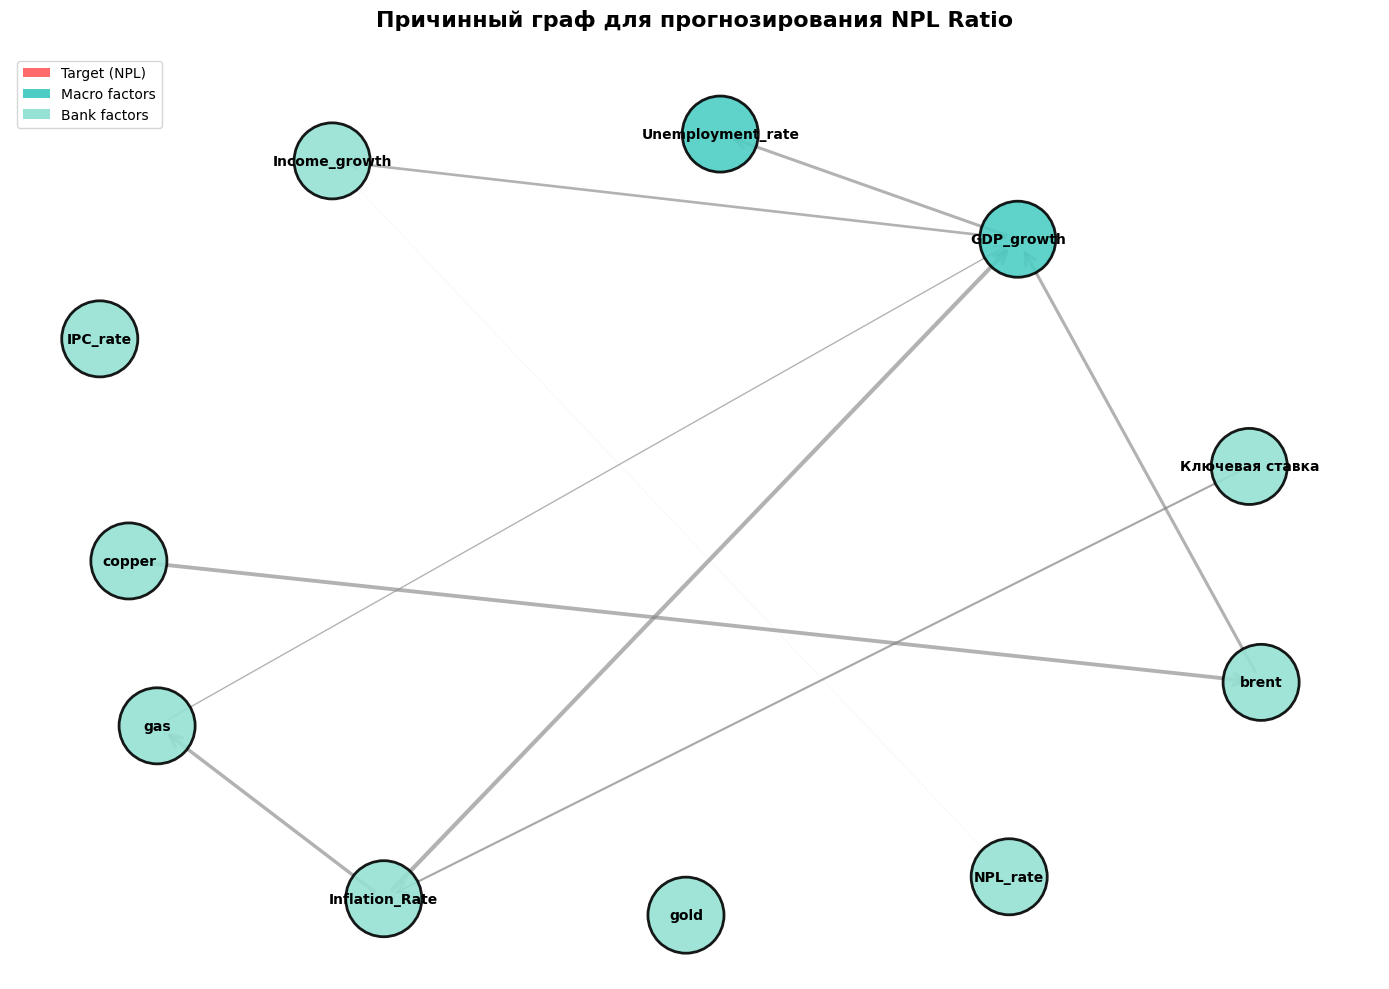

In [93]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_causal_graph(graph, variables, causal_effects=None, 
                          save_path='causal_graph_npl.png'):
    """
    Визуализация причинного графа
    """
    # Создаем направленный граф
    G = nx.DiGraph()
    
    # Добавляем узлы
    for var in variables:
        G.add_node(var)
    
    # Добавляем ребра с весами
    n = len(variables)
    for i in range(n):
        for j in range(n):
            if graph[i, j] == 1:
                weight = causal_effects[i, j] if causal_effects is not None else 1
                G.add_edge(variables[i], variables[j], weight=abs(weight))
    
    # Настройка визуализации
    plt.figure(figsize=(14, 10))
    
    # Иерархическое расположение (по уровням причинности)
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    
    # Цвета узлов по типу
    node_colors = []
    for var in variables:
        if var == 'NPL_ratio':
            node_colors.append('#ff6b6b')  # красный для целевой переменной
        elif 'GDP' in var or 'Unemployment' in var or 'Interest' in var:
            node_colors.append('#4ecdc4')  # голубой для макро
        else:
            node_colors.append('#95e1d3')  # зеленый для банковских
    
    # Рисуем узлы
    nx.draw_networkx_nodes(G, pos, 
                          node_color=node_colors,
                          node_size=3000,
                          alpha=0.9,
                          edgecolors='black',
                          linewidths=2)
    
    # Рисуем ребра с толщиной пропорциональной силе связи
    if causal_effects is not None:
        edges = G.edges()
        weights = [G[u][v]['weight'] for u, v in edges]
        max_weight = max(weights) if weights else 1
        edge_widths = [3 * w / max_weight for w in weights]
    else:
        edge_widths = [2] * len(G.edges())
    
    nx.draw_networkx_edges(G, pos,
                          width=edge_widths,
                          alpha=0.6,
                          edge_color='gray',
                          arrows=True,
                          arrowsize=20,
                          arrowstyle='->')
    
    # Подписи узлов
    nx.draw_networkx_labels(G, pos,
                           font_size=10,
                           font_weight='bold',
                           font_family='sans-serif')
    
    # Легенда
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#ff6b6b', label='Target (NPL)'),
        Patch(facecolor='#4ecdc4', label='Macro factors'),
        Patch(facecolor='#95e1d3', label='Bank factors')
    ]
    plt.legend(handles=legend_elements, loc='upper left', fontsize=10)
    
    plt.title('Причинный граф для прогнозирования NPL Ratio', 
             fontsize=16, fontweight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Визуализируем граф
visualize_causal_graph(oriented_graph, variables, causal_effects)